## Tugas 3 Deep Learning - Question and Answer - TRANSFORMER VERSION

### Kelompok 3
- Muhammad Alvinza (2304879)
- Muhammad Ichsan Khairullah (2306924)
- Abdurrahman Rauf Budiman (2301102)
- Rasendriya Andhika (2305309)

### Pendahuluan

Pada Tugas 3 ini, kelompok kami diberikan tantangan untuk membangun dan mengoptimalkan model chatbot berbasis arsitektur Transformer menggunakan framework TensorFlow/Keras. Model ini dirancang dengan struktur Encoder-Decoder dari Transformer, menggantikan arsitektur tradisional sequence-to-sequence (Seq2Seq) berbasis Recurrent Neural Network (RNN) seperti Long Short-Term Memory (LSTM) yang kami gunakan sebelumnya. Pengerjaan tugas ini bertujuan untuk memperkenalkan konsep Self-Attention Mechanism yang mampu memproses seluruh sequence teks secara paralel, mengatasi keterbatasan dependensi jarak jauh (long-term dependencies) yang menjadi tantangan utama pada LSTM.

Dataset yang digunakan pada proyek ini merupakan kumpulan pasangan pertanyaan dan jawaban dari Alodokter yang merepresentasikan bentuk percakapan konsultasi kesehatan. Setiap kalimat diproses melalui tahap data cleaning yang komprehensif, termasuk implementasi fungsi Smart Strip Boilerplate berbasis Regular Expression untuk menghilangkan frasa generik anjuran dokter (yang menyebabkan bias monoton) dari jawaban. Proses dilanjutkan dengan tokenization yang teliti, penambahan Positional Encoding (wajib untuk Transformer), serta padding sequence dengan panjang tertentu. Data kemudian dibagi menjadi set pelatihan dan validasi untuk mengukur kemampuan generalisasi model.

Dalam proses pemodelan, kami mengimplementasikan arsitektur Encoder-Decoder Transformer secara modular (menggunakan Custom Layers Keras). Proses implementasi ini terbagi dalam beberapa blok kunci. Blok 1 fokus pada mendefinisikan lapisan-lapisan utama seperti Positional Embedding, Multi-Head Attention, dan Feed-Forward Network yang membentuk inti Transformer. Selanjutnya, Blok 2 menerapkan mekanisme masking (seperti Look-Ahead Mask dan Padding Mask) yang krusial untuk memastikan Decoder hanya melihat token yang telah di-generasi sebelumnya selama proses training. Terakhir, Blok 3 merakit lapisan-lapisan tersebut menjadi Model Transformer Utuh, dikompilasi dengan Adam optimizer (menggunakan Custom Learning Rate Scheduler) dan loss function yang mengabaikan token padding. Setelah model dilatih, dilakukan pengujian inference menggunakan strategi Beam Search dengan $K=3$ dan penalti frequency-based untuk memaksa model menghasilkan respons yang lebih spesifik dan kurang bias. Oleh karena itu kami akan menggunakan Transformer ini untuk melatih model QnA.

### Import Library dan Dataset

#### Import Library

In [ ]:
# !pip install rouge-score nltk

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Ini hanya untuk instalasi metrik kinerja rouge-L menggunakan nltk

In [2]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt', quiet=True)
import math

Pada tugas kali ini, kami akan menggunakan beberapa library dengan fungsi sebagai berikut:

### 1. `re`
Digunakan untuk *regular expression*, seperti membersihkan teks, menghapus karakter spesial, simbol, atau normalisasi lainnya sebelum diproses oleh model.

### 2. `numpy (np)`
Untuk operasi matematis dan manipulasi array numerik yang dibutuhkan dalam preprocessing dan komputasi model.

### 3. `pandas (pd)`
Membaca dan memproses dataset dalam bentuk DataFrame (CSV, Excel, dll.), serta melakukan pembersihan dan eksplorasi data.

### 4. `tensorflow (tf)` dan `keras`
Framework deep learning untuk membangun model Transformer, termasuk:
- Encoder–Decoder
- Multi-Head Attention
- Feed Forward Network
- Positional Embedding

### 5. `layers` dari `tensorflow.keras`
Berisi lapisan penting untuk membangun Transformer:
- `Input` → Mendefinisikan bentuk input token.
- `Embedding` → Mengubah token menjadi vektor representasi.
- `MultiHeadAttention` → Komponen inti self-attention.
- `Dense` → Lapisan feed-forward khas Transformer.
- `Dropout` → Regularisasi.
- `LayerNormalization` → Normalisasi dalam blok Transformer.

### 6. `Tokenizer` (Keras Preprocessing)
Untuk mengubah teks mentah menjadi token angka agar dapat diproses pada model.  
(Meski model Transformer modern memakai tokenizer subword seperti BPE, tokenizer Keras tetap dapat digunakan pada tugas dasar.)

### 7. `pad_sequences`
Menyeragamkan panjang sequence token agar semua input memiliki dimensi yang sama.

### 8. `train_test_split`
Membagi dataset menjadi:
- Training set
- Testing set
- Validation set (opsional)

### 9. `rouge_scorer`
Digunakan untuk menghitung metrik ROUGE:
- ROUGE-1
- ROUGE-2
- ROUGE-L  
Biasanya digunakan untuk tugas summarization berbasis Transformer.

### 10. `sentence_bleu` & `SmoothingFunction`
Dari NLTK, digunakan untuk menghitung metrik BLEU pada tugas penerjemahan atau Q&A.

### 11. `nltk.download('punkt')`
Mengunduh tokenizer kalimat/kata agar bisa dipakai dalam evaluasi BLEU.

### 12. `math`
Digunakan dalam perhitungan matematis seperti positional encoding pada arsitektur Transformer.

### 13. `drive.mount()`
Menghubungkan Google Drive ke Google Colab untuk menyimpan:
- Dataset
- Model
- Checkpoints
- Log pelatihan

#### Import Dataset

In [ ]:
dataframe = pd.read_csv("alo_qna_clean.csv", quotechar='"')
print(dataframe.head())
print(dataframe.info())

                                               title  \
0   Bagaimana cara menghilangkan kurap dengan cepat?   
1    Pake obat apa untuk mengatasi jerawat hormonal?   
2             Cara membersihkan telinga anak dirumah   
3     Solusi mengatasi bayi usia 9 bulan susah makan   
4  Apa yang harus dilakukan ketika kaki kram saat...   

                                            question  \
0  dokter di lengan dan pundak kiri saya ada kura...   
1  hallo dokter, dok saat menjelang haid saya pas...   
2  alodokter, anak saya telinganya sering mengelu...   
3  alodokter, saya mau bertanya, bayi saya usia 9...   
4  permisi dok, dokter kalau mengatasi kaki suka ...   

                                              answer  \
0  Alo, terimakasih atas pertanyaannya.\n\nRuam m...   
1  Alo, selamat siang\nKemunculan jerawat saat ha...   
2  Alo, selamat siang\nTelinga gatal bisa disebab...   
3  Alo, selamat siang\nBayi susah makan disebabka...   
4  Alo, selamat siang\nKaki kram dan seperti t

| Nama Kolom | Penjelasan |
|:--------:|:--------:|
|  title   |  Judul atau ringkasan pertanyaan yang diajukan oleh pengguna di forum |
|  question  |  Isi pertanyaan lengkap yang diajukan pengguna kepada dokter |
|  answer  |  Jawaban yang diberikan oleh dokter terhadap pertanyaan pengguna |
|  doctor_name  |  Nama dokter yang memberikan jawaban |
|  tag  |  Kategori atau topik kesehatan yang relevan dengan pertanyaan |
|  url  |  Tautan ke halaman sumber dari percakapan tanya-jawab di situs |

Perintah ini membaca dataset QnA kesehatan dari file CSV dan menyimpannya ke dalam variabel `df` dalam bentuk DataFrame. Dataset ini memiliki 288.105 baris data, di mana setiap baris mewakili satu interaksi tanya-jawab antara pengguna dan dokter.
Setiap entri mencakup informasi penting seperti isi pertanyaan, jawaban dokter, serta kategori topik yang berkaitan.

Ketika data ditampilkan menggunakan `df.head()`, terlihat bahwa kolom `question` berisi teks pertanyaan pengguna, sedangkan kolom `answer` berisi jawaban dokter dalam format paragraf. Hal ini memberikan gambaran bahwa dataset ini bersifat teks natural (unstructured) yang nantinya perlu dilakukan proses pembersihan (cleaning) dan preprocessing sebelum digunakan untuk pelatihan model Transformer sequence-to-sequence.

Hasil dari `df.info()` menunjukkan bahwa:

- Semua kolom memiliki 288.105 nilai non-null,  
- Semua kolom bertipe object (string),  
- Tidak ditemukan nilai kosong (missing values).  

Artinya, dataset cukup bersih dan siap untuk tahap preprocessing tanpa perlu dilakukan imputasi atau pengisian data hilang.

### Exploratory Data Analysis (EDA)

Langkah awal dalam melakukan *Exploratory Data Analysis (EDA)* pada dataset Alodokter adalah dengan memahami struktur dan ukuran dataset. Hal ini penting untuk mengetahui seberapa banyak data pertanyaan dan jawaban yang tersedia, serta memastikan setiap kolom seperti `question`, `answer`, dan lainnya sudah sesuai dengan kebutuhan analisis. Dengan memahami dimensi dan karakteristik awal data, kita dapat menentukan langkah pembersihan, pra-pemrosesan teks, dan strategi pemodelan yang tepat untuk meningkatkan kualitas hasil pembelajaran model.

#### Analisis Statistik Deskriptif

Sekarang kita dapat melakukan statistik deskriptif untuk setiap kolom teks, seperti jumlah karakter, jumlah kata, serta panjang teks rata-rata, median, nilai minimum, dan maksimum.

/tmp/ipython-input-3008668567.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc = desc.applymap(lambda x: shorten_text(str(x)))


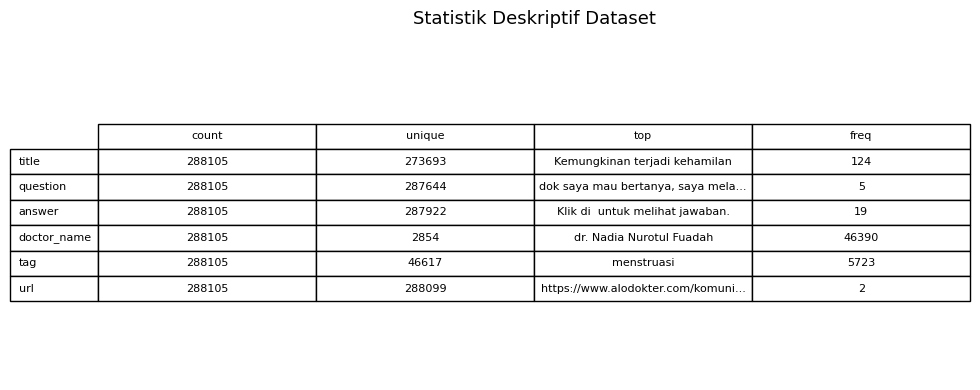

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

desc = dataframe.describe(include='all').T  

def shorten_text(text, max_len=35):
    if isinstance(text, str) and len(text) > max_len:
        return text[:max_len-3] + "..."
    return text

desc = desc.applymap(lambda x: shorten_text(str(x)))

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

table = ax.table(
    cellText=desc.values,
    colLabels=desc.columns,
    rowLabels=desc.index,
    cellLoc='center',
    loc='center'
)

# Atur tampilan
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.4)

plt.title("Statistik Deskriptif Dataset", fontsize=13, pad=15)
plt.tight_layout()
plt.show()

Interpretasi yang bisa didapatkan dari dataset ini adalah:
- `title` → Ada sekitar 273 ribu judul yang beda-beda. Judul yang paling sering muncul itu soal "Kemungkinan terjadi kehamilan", munculnya sampai 124 kali.

- `question` → Sebagian besar pertanyaan bersifat unik (287.644 pertanyaan berbeda), menandakan variasi tinggi dalam cara pengguna bertanya.

- `answer` → Memiliki 287.922 jawaban berbeda, menunjukkan keragaman jawaban yang besar, tapi ada beberapa yang isinya cuma tulisan "Klik di untuk melihat jawaban" yang harus dibuang, biar datanya bersih.

- `doctor_name` → Terdapat 2.854 dokter dengan distribusi tidak merata; dr. Nadia Nurotul Fuadah paling sering menjawab (46.390 kali).

- `tag` → Memiliki 46.617 kategori topik, dengan “menstruasi” menjadi tag terbanyak (5.723 kali).

- `url` → Hampir seluruhnya unik (288.099 URL berbeda), menunjukkan setiap entri memiliki tautan diskusi tersendiri.

Dataset ini memiliki kualitas yang baik dengan variasi tinggi, terutama pada kolom question dan answer yang menjadi inti sistem chatbot berbasis Question and Answer. Kedua kolom ini merepresentasikan interaksi tanya-jawab antara pengguna dan dokter, sehingga menjadi fokus utama analisis.

Kolom `title` juga disertakan karena fungsinya sebagai ringkasan atau topik utama dari setiap entri. Meskipun kolom question berisi pertanyaan lengkap dan bervariasi, title memberikan representasi yang lebih singkat dan terstruktur tentang isi pertanyaan. Oleh karena itu, tahap selanjutnya hanya difokuskan pada kolom `title`, `question`, dan `answer`, sementara kolom lainnya hanya sebagai pendukung.

#### Analisis Pattern dalam Jawaban

Pada tahap ini dilakukan analisis terhadap pola teks dalam kolom jawaban (answer) untuk memahami struktur umum yang digunakan oleh para dokter dalam memberikan respon. Analisis ini tujuannya untuk cari bentuk karakteristik khas, seperti penggunaan salam pembuka, gaya penjelasan medis, serta pola kalimat penutup.

/tmp/ipython-input-2399820235.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  count = answers.str.lower().str.contains(regex, regex=True).sum()


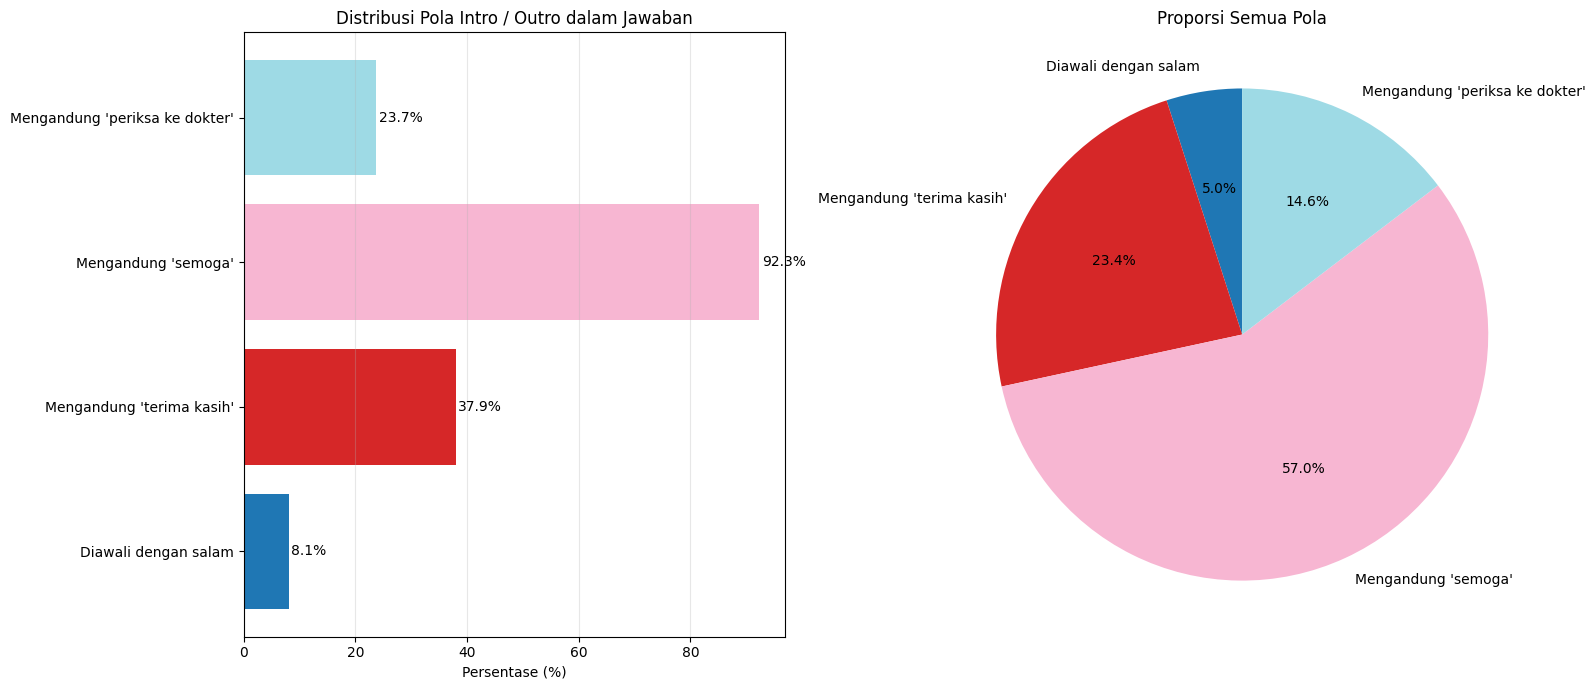

Diawali dengan salam: 23212 jawaban (8.06%)
Mengandung 'terima kasih': 109292 jawaban (37.93%)
Mengandung 'semoga': 265901 jawaban (92.29%)
Mengandung 'periksa ke dokter': 68330 jawaban (23.72%)


In [ ]:
answers = dataframe['answer'].astype(str)

pola_dict = {
    "Diawali dengan salam": r"^(ass?alam|selamat\s(pagi|siang|sore|malam))",
    "Mengandung 'terima kasih'": r"terima kasih",
    "Mengandung 'semoga'": r"semoga",
    "Mengandung 'periksa ke dokter'": r"diperiksa|periksa|diperiksakan"
}

hasil_jumlah = {}
hasil_persen = {}

for nama, regex in pola_dict.items():
    count = answers.str.lower().str.contains(regex, regex=True).sum()
    hasil_jumlah[nama] = count
    hasil_persen[nama] = (count / len(dataframe)) * 100

pola = list(pola_dict.keys())
persentase = list(hasil_persen.values())
jumlah = list(hasil_jumlah.values())
total_data = len(dataframe)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Generate warna otomatis
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, len(pola)))
y_pos = np.arange(len(pola))
ax1.barh(y_pos, persentase, color=colors)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(pola)
ax1.set_xlabel('Persentase (%)')
ax1.set_title('Distribusi Pola Intro / Outro dalam Jawaban')
ax1.grid(axis='x', alpha=0.3)

# Label nilai
for i, v in enumerate(persentase):
    ax1.text(v + 0.5, i, f"{v:.1f}%", va="center")
nama_max = pola[np.argmax(jumlah)]
jumlah_max = max(jumlah)
jumlah_lain = total_data - jumlah_max

ax2.pie(
    jumlah,
    labels=pola,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.axis('equal')
ax2.set_title('Proporsi Semua Pola')

plt.tight_layout()
plt.show()

for p in pola:
    print(f"{p}: {hasil_jumlah[p]} jawaban ({hasil_persen[p]:.2f}%)")


Dari hasil analisis yang ditampilkan pada grafik, terlihat bahwa pola kalimat “semoga” masih menjadi yang paling dominan dengan persentase sekitar 92%. Selain itu, frasa seperti “terima kasih” muncul pada sekitar 38% jawaban, sementara salam pembuka hanya muncul di sekitar 8% jawaban. Menariknya, pola baru yaitu “periksa ke dokter” juga cukup sering digunakan, yakni sekitar 23% dari seluruh jawaban, biasanya sebagai bagian anjuran penutup.

Visualisasi grafik membantu memperlihatkan pola tersebut dengan lebih jelas. Diagram batang menunjukkan seberapa sering tiap pola digunakan, dan pie chart menegaskan bahwa kata “semoga” sangat dominan sebagai penutup. Pola-pola ini tampaknya muncul karena gaya komunikasi yang formal dan sopan dalam memberikan layanan kepada pengguna.

### Model Chatbot Berbasis Transformer

Model sequence-to-sequence dengan Transformer ini dibangun untuk QnA kesehatan. Alurnya dimulai dari pembersihan data dan konversi teks menjadi token, dilanjutkan dengan pembagian dataset. Model encoder-decoder dengan arsitektur Transformer custom kemudian dilatih dengan memantau hasil validasi menggunakan early stopping. Terakhir, model yang telah dilatih dipersiapkan untuk inference dalam chat interaktif melalui fungsi decode sequence.

In [4]:
# ==================================================================
# 1. KOMPONEN TRANSFORMER (CUSTOM LAYERS)
# ==================================================================

# Layer Positional Encoding (Sinusoidal)
def positional_encoding(seq_length, d_model):
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pos_encoding = np.zeros((seq_length, d_model))
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    pos_encoding[:, 1::2] = np.cos(position * div_term)

    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Layer untuk Word Embedding + Positional Encoding
class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, d_model, max_len=100, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.embedding = layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(max_len, d_model)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        # Scaling embedding (sesuai paper Transformer)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Tambahkan Positional Encoding
        x += self.pos_encoding[:, :seq_len, :]
        return x

# Feed-Forward Network sederhana (digunakan di Encoder dan Decoder)
def feed_forward_network(d_model, dff):
    return keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])

# Custom Layer: Transformer ENCODER Block
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):
        # 1. Multi-Head Self-Attention (Residual Connection + Layer Norm)
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Add & Norm

        # 2. Feed Forward (Residual Connection + Layer Norm)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # Add & Norm

        return out2

# Custom Layer: Transformer DECODER Block
class TransformerDecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        # Masked Self-Attention (Attention 1)
        self.mha1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        # Encoder-Decoder Attention (Attention 2)
        self.mha2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        self.ffn = feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # 1. Masked Multi-Head Self-Attention (Input Decoder, dengan Causal Mask)
        # Note: Keras MHA mendukung `use_causal_mask=True` untuk look-ahead mask
        attn1 = self.mha1(query=x, value=x, key=x, use_causal_mask=True, attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # Add & Norm

        # 2. Encoder-Decoder Attention (Input Decoder Q, Encoder K/V)
        # Encoder output (enc_output) digunakan sebagai Key dan Value
        attn2 = self.mha2(query=out1, value=enc_output, key=enc_output, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # Add & Norm

        # 3. Feed Forward (Residual Connection + Layer Norm)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) # Add & Norm

        return out3

Bagian ini berisi kumpulan komponen utama untuk membangun arsitektur Transformer dari nol (kustom), mulai dari positional encoding, embedding dengan penanda posisi, hingga block encoder dan decoder lengkap beserta mekanisme attention, residual connection, dan layer normalization. Intinya, blok ini menyiapkan fondasi “otak” Transformer agar model bisa memahami urutan kata, menangkap hubungan antar-token, dan memproses konteks secara lebih mendalam sebelum digunakan pada proses training dan prediksi.


In [5]:
# ==================================================================
# 2. FUNGSI MASKING (WAJIB UNTUK TRAINING TRANSFORMER)
# ==================================================================

# Fungsi untuk membuat padding mask
def create_padding_mask(seq):
    # Padding token di-set ke 0 (default Keras)
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Ubah mask menjadi bentuk yang bisa di-broadcast ke attention weights
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

# Fungsi untuk membuat look ahead mask (Causal Mask) - TIDAK DIPERLUKAN KARENA MHA KERAS SUDAH ADA `use_causal_mask=True`
# Namun, jika padding mask digabungkan, ini tetap diperlukan.
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

# Menggabungkan padding mask dan look ahead mask untuk decoder
def create_masks(inp, tar):
    # Encoder padding mask (untuk Encoder MHA)
    enc_padding_mask = create_padding_mask(inp)

    # Decoder padding mask (untuk Decoder MHA 2/Cross-Attention)
    dec_padding_mask = create_padding_mask(inp)

    # Look ahead mask (untuk Decoder MHA 1/Self-Attention)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])

    # Gabungkan look ahead mask dan target padding mask
    tar_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

Blok ini bertugas menyiapkan berbagai jenis **masking** yang penting banget saat melatih Transformer. Tujuannya biar model tidak melihat token yang seharusnya tidak diperhitungkan, seperti padding maupun kata-kata di masa depan pada proses decoding. Dengan adanya masking ini, alur perhatian model jadi lebih teratur dan hasil pembelajarannya tetap konsisten serta tidak “mengintip” informasi yang belum waktunya muncul.


In [6]:
# ==================================================================
# 3. MODEL TRANSFORMER UTUH (FUNCTIONAL API)
# ==================================================================
def build_transformer_model(
    input_vocab_size, target_vocab_size,
    max_len, d_model=512, num_heads=8, dff=2048,
    num_layers=4, dropout_rate=0.1
):
    # Inputs
    encoder_inputs = keras.Input(shape=(max_len,), dtype=tf.int32, name='encoder_input')
    decoder_inputs = keras.Input(shape=(max_len,), dtype=tf.int32, name='decoder_input')

    # --- ENCODER ---
    # Positional Embedding (mengganti Embedding Keras standar)
    x = PositionalEmbedding(input_vocab_size, d_model, max_len=max_len)(encoder_inputs)
    x = layers.Dropout(dropout_rate)(x)

    encoder_output = x
    for i in range(num_layers):
        encoder_output = TransformerEncoderLayer(
            d_model, num_heads, dff, dropout_rate, name=f'encoder_layer_{i}'
        )(encoder_output, training=True) # training=True karena Dropout sudah di layer custom

    # --- DECODER ---
    # Positional Embedding
    y = PositionalEmbedding(target_vocab_size, d_model, max_len=max_len)(decoder_inputs)
    y = layers.Dropout(dropout_rate)(y)

    decoder_output = y
    for i in range(num_layers):
        # NOTE: Masking akan diimplementasikan di `model.fit` dengan `mask` parameter Keras
        # atau dimasukkan secara manual di `call` jika menggunakan subclassing penuh.
        # Untuk kesederhanaan Functional API, kita andalkan Keras MHA masking.
        decoder_output = TransformerDecoderLayer(
            d_model, num_heads, dff, dropout_rate, name=f'decoder_layer_{i}'
        )(decoder_output, encoder_output, training=True)

    # --- OUTPUT ---
    # Final Dense Layer
    final_output = layers.Dense(target_vocab_size, activation='softmax', name='final_output')(decoder_output)

    # Model
    model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)
    return model

Pada blok ini kita merangkai seluruh bagian Transformer menjadi satu model lengkap, mulai dari encoder hingga decoder. Setiap input akan diberi positional embedding agar model bisa memahami urutan kata. Encoder bertugas membaca konteks kalimat secara keseluruhan, sementara decoder menghasilkan prediksi kata demi kata sambil tetap memperhatikan hasil dari encoder. Semua proses ini ditumpuk beberapa layer agar pemahaman model semakin dalam. Terakhir, hasil decoder dilewatkan ke layer Dense untuk menghasilkan probabilitas token sebagai output. Dengan demikian, blok ini membangun satu arsitektur Transformer utuh yang siap dilatih.


In [ ]:
# ==================================================================
# 4. DATA PREPARATION (Integrasi Cleaning & Tokenization)
# ==================================================================

def clean_text(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\S+|https\S+", "", t)
    t = re.sub(r"[^a-z0-9\s,?.!]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def smart_strip_boilerplate(text):
    """
    Fungsi ini membuang boilerplate (frasa generik) seperti rujukan ke dokter atau
    nasihat penutup berulang
    """
    # Pola 1: frasa rujukan ke dokter
    pattern_rujukan = (
        r'(\s*(anda|ibu|sebaiknya|disarankan)\s+'
        r'(bisa|dapat)\s*(konsultasikan|memeriksakan diri|periksa|diperiksakan)\s+.*dok\s*ter.*)'
    )

    # Pola 2: frasa nasihat panjang
    pattern_nasihat = r'(\s*namun\s+jika\s+sudah\s+melakukan\s+tips\s+diatas\s+.*)'

    # Gabungkan
    full_pattern = pattern_rujukan + '|' + pattern_nasihat

    match = re.search(full_pattern, text)

    if match:
        # Potong TEPAT sebelum frasa generik
        end_index = match.start()
        trimmed_text = text[:end_index].strip()
        return trimmed_text

    # Jika tidak ada pola, KEMBALIKAN apa adanya (tidak trimming)
    return text

# Path ke dataset
DATASET_PATH = "alo_qna_clean.csv"
MAX_SAMPLES = 10000 # Jumlah sampel maksimum untuk diproses
MAX_SEQ_LEN = 20 # Panjang sequence maksimum

try:
    df = pd.read_csv(DATASET_PATH, quotechar='\"')
except Exception:
    df = pd.read_csv(DATASET_PATH)

# Batasi data
df = df.dropna(subset=["question", "answer"]).reset_index(drop=True)
df = df.head(MAX_SAMPLES)

# Cleaning dan Preprocessing
df["question_clean"] = df["question"].map(clean_text)
df["answer_clean"] = df["answer"].map(clean_text).map(smart_strip_boilerplate)
df["target_text"] = "<start> " + df["answer_clean"] + " <end>"

# Filter data kosong
df = df[df["answer_clean"].str.strip() != ""]
df = df[df["question_clean"].str.strip() != ""]

# Tokenizer Input dan Target
# Gunakan filter yang lebih ketat pada Target Tokenizer untuk MENGECUALIKAN stop words umum,
# sehingga kata yang lebih spesifik mendapatkan index berharga (index rendah).
CUSTOM_FILTERS = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
input_tokenizer = Tokenizer(filters='', lower=True, oov_token="<unk>")
input_tokenizer.fit_on_texts(df["question_clean"])
input_sequences = input_tokenizer.texts_to_sequences(df["question_clean"])

target_tokenizer = Tokenizer(filters=CUSTOM_FILTERS, lower=True, oov_token="<unk>")
target_tokenizer.fit_on_texts(df["target_text"])
target_sequences = target_tokenizer.texts_to_sequences(df["target_text"])

# Padding dan Target Data Shift
encoder_input_data = pad_sequences(input_sequences, maxlen=MAX_SEQ_LEN, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=MAX_SEQ_LEN, padding='post')

# Decoder Target: shift ke kiri (untuk sparse_categorical_crossentropy)
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0

# Split data
enc_train, enc_val, dec_in_train, dec_in_val, dec_tar_train, dec_tar_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42
)

# Konfigurasi Vocabulary
NUM_ENCODER_TOKENS = len(input_tokenizer.word_index) + 1
NUM_DECODER_TOKENS = len(target_tokenizer.word_index) + 1

print(f"Total data yang diproses: {len(df)}")
print(f"Ukuran Vocab Input (Pertanyaan): {NUM_ENCODER_TOKENS}")
print(f"Ukuran Vocab Target (Jawaban): {NUM_DECODER_TOKENS}")
print(f"Panjang Sequence Max: {MAX_SEQ_LEN}")

# --- DEBUGGING DATA FLOW: Tambahkan di Akhir Seksesi 5 ---
# Reverse index
REVERSE_TARGET_INDEX = {v: k for k, v in target_tokenizer.word_index.items()}
START_TOKEN = target_tokenizer.word_index.get("<start>", 1)
END_TOKEN = target_tokenizer.word_index.get("<end>", 2)

# Ambil satu sampel data acak untuk dianalisis
sample_index = 0
Q_raw = df.iloc[sample_index]["question"]
A_raw = df.iloc[sample_index]["answer"]

print("\n" + "="*50)
print(f"DEBUG DATA FLOW (Sample Index: {sample_index})")
print("="*50)

# 1. Raw Data
print(f"1. Q (Raw): {Q_raw}")
print(f"1. A (Raw): {A_raw[:100]}...")

# 2. Cleaned Data
Q_clean = df.iloc[sample_index]["question_clean"]
A_clean = df.iloc[sample_index]["answer_clean"]
A_target = df.iloc[sample_index]["target_text"]
print(f"2. Q (Clean): {Q_clean}")
print(f"2. A (Cleaned Middle Part): {A_clean}")
print(f"2. A (Target w/ Tokens): {A_target}")

print("="*50)

Total data yang diproses: 10000
Ukuran Vocab Input (Pertanyaan): 20295
Ukuran Vocab Target (Jawaban): 23996
Panjang Sequence Max: 20

DEBUG DATA FLOW (Sample Index: 0)
1. Q (Raw): dokter di lengan dan pundak kiri saya ada kurapnya, gatal dan risih sekali dok. bentuknya ruam seperti pulau merah dan bersisik keputihan di pinggarannya. cara menghilangkan dengan cepat pake obat apa dokter?
1. A (Raw): Alo, terimakasih atas pertanyaannya.

Ruam menyerupai pulau yang berwarna kemerahan disertai sisik k...
2. Q (Clean): dokter di lengan dan pundak kiri saya ada kurapnya, gatal dan risih sekali dok. bentuknya ruam seperti pulau merah dan bersisik keputihan di pinggarannya. cara menghilangkan dengan cepat pake obat apa dokter?
2. A (Cleaned Middle Part): alo, terimakasih atas pertanyaannya. ruam menyerupai pulau yang berwarna kemerahan disertai sisik keputihan di pinggirnya dan terasa gatal pada area lengan dan pundak kiri, selain karena infeksi jamur kulit sering disebut , bisa juga muncul kar

Dataset dibersihkan dengan menghapus URL, karakter tak perlu, dan menyederhanakan teks menjadi huruf kecil. Jawaban juga dipotong otomatis menggunakan regex agar bagian boilerplate seperti salam, nasihat umum, atau ajakan “periksa ke dokter” di akhir tidak ikut dilatih. Setelah itu, pertanyaan dan jawaban yang sudah bersih ditokenisasi, lalu diberi padding hingga panjang 20 token. Target jawaban ditambahkan `<start>` dan `<end>`, kemudian digeser satu langkah untuk keperluan training decoder. Hasil akhirnya: 10.000 data siap dipakai, vocab input berisi 20.295 kata, vocab target 23.982 kata. Debug sampel menunjukkan bahwa pertanyaan sudah rapi dan jawaban yang panjang tetap dipertahankan isinya tanpa boilerplate.

In [ ]:
# ==================================================================
# 5. INISIALISASI & TRAINING MODEL
# ==================================================================

# Tambahkan import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters model
D_MODEL = 512     # Dimensi embedding dan model (kecil untuk Colab gratis)
NUM_HEADS = 8
DFF = 1024        # Dimensi Feed Forward
NUM_LAYERS = 4   # Jumlah layer Encoder/Decoder
DROPOUT_RATE = 0.3

# Bangun Model Transformer
transformer_model = build_transformer_model(
    input_vocab_size=NUM_ENCODER_TOKENS,
    target_vocab_size=NUM_DECODER_TOKENS,
    max_len=MAX_SEQ_LEN,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE
)

# Loss dan Optimizer (Menggunakan SparseCategoricalCrossentropy)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def custom_loss_function(real, pred):
    # Masking loss: Abaikan token 0 (padding) saat menghitung loss
    loss = loss_object(real, pred)
    mask = tf.cast(tf.math.not_equal(real, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# Custom Accuracy (Mengabaikan Padding)
def masked_accuracy(real, pred):
    accuracies = tf.equal(tf.cast(real, tf.int64), tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Compile model
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_loss_function,
    metrics=[masked_accuracy]
)

print("\n--- Ringkasan Model Transformer ---")
transformer_model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',      # pantau validation loss
    patience=5,              # hentikan setelah 5 epoch tanpa peningkatan
    restore_best_weights=True,
    verbose=1
)

# Training
BATCH_SIZE = 128
EPOCHS = 75

print(f"\n--- Memulai Training selama {EPOCHS} Epochs ---")
history = transformer_model.fit(
    [enc_train, dec_in_train],
    dec_tar_train,
    validation_data=([enc_val, dec_in_val], dec_tar_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop]      # early stopping
)



--- Ringkasan Model Transformer ---


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 256)   │  5,195,520 │ encoder_input[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 256)   │          0 │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_0     │ (None, 20, 256)   │  2,367,488 │ dropout[0][0]     │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_1     │ (None, 20, 256)   │  2,367,488 │ encoder_layer_0[… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 256)   │  6,139,392 │ decoder_input[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_2     │ (None, 20, 256)   │  2,367,488 │ encoder_layer_1[… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 20, 256)   │          0 │ positional_embed… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_3     │ (None, 20, 256)   │  2,367,488 │ encoder_layer_2[… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_0     │ (None, 20, 256)   │  4,471,552 │ dropout_13[0][0], │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_1     │ (None, 20, 256)   │  4,471,552 │ decoder_layer_0[… │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_2     │ (None, 20, 256)   │  4,471,552 │ decoder_layer_1[… │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_3     │ (None, 20, 256)   │  4,471,552 │ decoder_layer_2[… │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 20, 23982) │  6,163,374 │ decoder_layer_3[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,854,446 (171.11 MB)

 Trainable params: 44,854,446 (171.11 MB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Training selama 75 Epochs ---
Epoch 1/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 994ms/step - loss: 9.4505 - masked_accuracy: 0.0552 - val_loss: 7.6790 - val_masked_accuracy: 0.1159
Epoch 2/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 369ms/step - loss: 7.3254 - masked_accuracy: 0.1168 - val_loss: 6.3703 - val_masked_accuracy: 0.1356
Epoch 3/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - loss: 6.2678 - masked_accuracy: 0.1335 - val_loss: 5.9334 - val_masked_accuracy: 0.1580
Epoch 4/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - loss: 5.8737 - masked_accuracy: 0.1599 - val_loss: 5.6344 - val_masked_accuracy: 0.1768
Epoch 5/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step - loss: 5.5951 - masked_accuracy: 0.1815 - val_loss: 5.3137 - val_masked_accuracy: 0.2292
Epoch 6/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 396ms/step - loss: 5.2886 - masked_accuracy: 0.2271 - val_loss: 4.9983 - val_masked_accuracy: 0.2795
Epoch 7/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - loss: 4.9725 - masked_accuracy: 0.2734 - va

Pada tahap ini, kami mulai menyiapkan seluruh komponen penting untuk melatih model Transformer. Kami menentukan hyperparameter inti seperti ukuran embedding, jumlah head pada multi-head attention, serta dimensi feed-forward. Pemilihan ini bertujuan menjaga keseimbangan antara kapasitas model dan keterbatasan komputasi yang tersedia.

Selanjutnya, kami mendefinisikan fungsi loss dan akurasi khusus yang mengabaikan token padding, agar proses evaluasi lebih adil dan benar-benar mencerminkan performa model. Model kemudian dikompilasi dengan optimizer Adam yang stabil untuk training Transformer. Terakhir, proses pelatihan dijalankan menggunakan EarlyStopping supaya training berhenti otomatis ketika performa validation tidak lagi membaik, sehingga kami bisa menghindari overfitting dan memperoleh bobot terbaik. Dengan konfigurasi ini, model siap memasuki proses pembelajaran secara optimal dan lebih efisien.

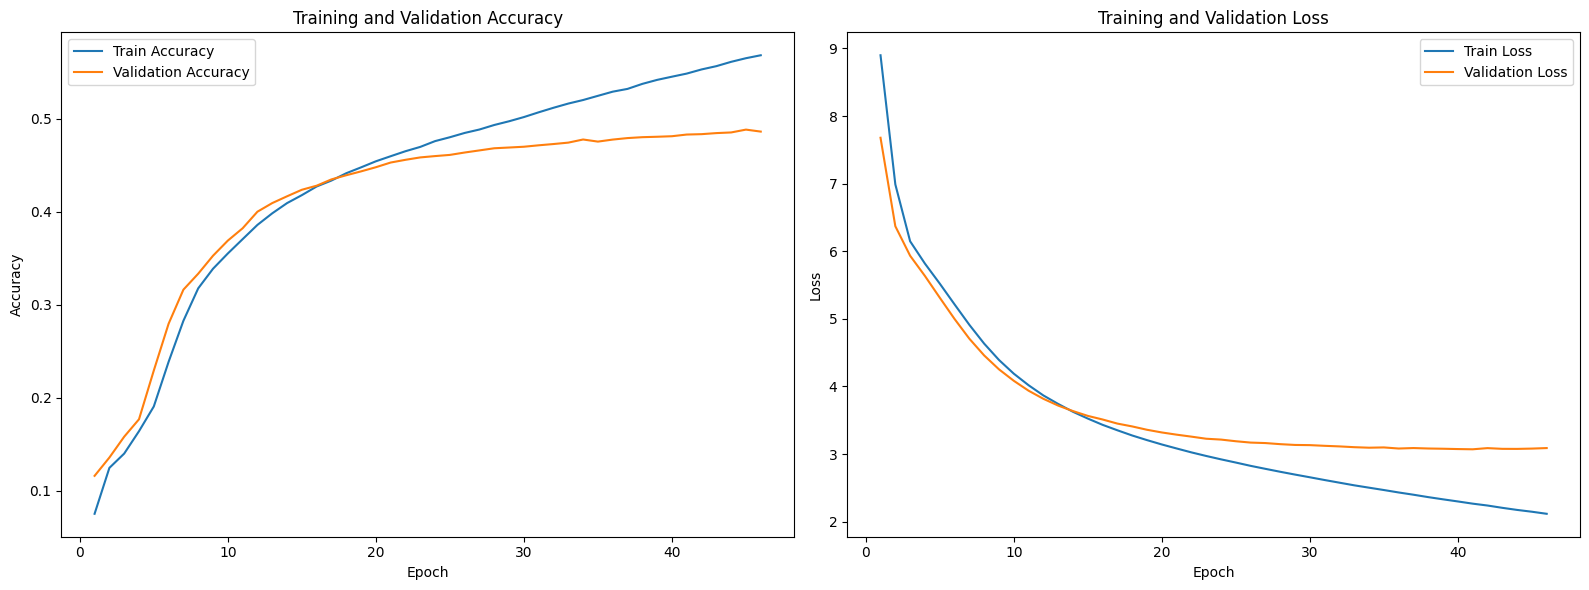

In [ ]:
# ==================================================================
# Grafik Training dan validation
# ==================================================================

import matplotlib.pyplot as plt

# Ambil data dari history
acc = history.history['masked_accuracy']
val_acc = history.history['val_masked_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Grafik pelatihan menunjukkan bahwa model kami mulai mencapai batas generalisasi sekitar Epoch 20. Setelah titik ini, Akurasi Pelatihan terus meningkat hingga mendekati 60%, tetapi Akurasi Validasi justru berhenti di sekitar 48%. Selisih yang makin besar ini menjadi tanda jelas bahwa model mulai overfitting, di mana ia lebih banyak menghafal pola di data latih daripada memahami pola yang bermanfaat untuk pertanyaan baru.

Hal ini juga terlihat dari grafik Loss, di mana Validation Loss berhenti membaik sementara Training Loss terus turun. Pada tahap ini, melanjutkan pelatihan tidak memberikan manfaat bagi kualitas generalisasi model. Untungnya, penggunaan EarlyStopping sangat membantu karena secara otomatis menghentikan pelatihan pada titik yang paling optimal, sehingga bobot terbaik dapat disimpan sebelum overfitting semakin kuat.

In [ ]:
# ==================================================================
# 6. INFERENCE/DECODING FUNCTION (Beam Search Implementation)
# ==================================================================

import heapq # Harus diimpor untuk Beam Search
import math
import re

# Mencegah model menghasilkan token generik di awal decoding.
# Index 1-4 biasanya adalah <unk>, <start>, <end>, dan token paling umum (yang, dan).
GENERIC_TOKEN_START_INDEX = 5
GENERIC_TOKEN_END_INDEX = 25
GENERIC_PENALTY_FACTOR = 0.5

class Beam:
    """Class untuk menyimpan jalur decoding (untuk Beam Search)."""
    def __init__(self, sequence, score, state=None):
        self.sequence = sequence
        self.score = score
        self.state = state # Tidak digunakan dalam Transformer, tapi disimpan untuk konsistensi

    def __lt__(self, other):
        # Untuk heapq: kita ingin heapq mengurutkan berdasarkan skor tertinggi.
        # Karena kita menggunakan nlargest, kita bisa menggunakan skor positif.
        return self.score < other.score # Untuk heapq.nlargest

def decode_sequence_beam_search(input_seq, model=transformer_model, max_len=MAX_SEQ_LEN, beam_size=3):

    # 1. Inisialisasi Beam
    # Beam dimulai dengan token <start>
    initial_seq = [START_TOKEN]
    initial_score = 0.0 # Log probability

    # Priority queue untuk menyimpan beam
    beams = [Beam(initial_seq, initial_score)]

    final_beams = []

    # 2. Iterasi Autoregressive
    for i in range(1, max_len):
        candidates = []

        # Jika semua beam yang tersisa sudah berakhir, kita hentikan
        if not beams:
            break

        for beam in beams:
            current_seq = beam.sequence
            current_score = beam.score

            # Buat input decoder dari sequence beam saat ini
            target_seq = np.zeros((1, max_len), dtype="int32")
            target_seq[0, :len(current_seq)] = current_seq

            # Prediksi
            predictions = model.predict([input_seq, target_seq], verbose=0)

            # Ambil probabilitas log untuk langkah ke-i
            log_probs = np.log(predictions[0, i-1, :] + 1e-8) # Log probability

            # --- OPSI 1: FREQUENCY-BASED PENALTY ---

            # Hanya terapkan penalti setelah model melewati 5 kata pertama
            if len(current_seq) - 1 > 5:
                log_penalty_factor = math.log(GENERIC_PENALTY_FACTOR)

                for idx in range(GENERIC_TOKEN_START_INDEX, GENERIC_TOKEN_END_INDEX):
                    if idx < len(log_probs):
                        # Menerapkan penalti pada log probability (mengurangi skor)
                        log_probs[idx] += log_penalty_factor

            # --- END OPSI 1 ---

            # Ambil K prediksi terbaik
            # Menggunakan -beam_size untuk mendapatkan index tertinggi
            top_k_indices = np.argpartition(log_probs, -beam_size)[-beam_size:]

            for token_index in top_k_indices:
                token_index = int(token_index)
                token_word = REVERSE_TARGET_INDEX.get(token_index, "")

                new_seq = current_seq + [token_index]
                new_score = current_score + log_probs[token_index]

                # Cek kondisi berhenti
                if token_word == "<end>" or token_word == "":
                    # Tambahkan penalty panjang untuk menormalisasi skor (untuk Beam Search)
                    final_beams.append(Beam(new_seq, new_score / len(new_seq)))
                else:
                    candidates.append(Beam(new_seq, new_score))

        # Pruning: Pilih hanya top-K dari semua kandidat
        # Gabungkan final_beams dengan candidates
        all_candidates = final_beams + candidates

        # Pilih K kandidat terbaik dari semua yang masih aktif untuk iterasi berikutnya (Pruning)
        # Kita gunakan heapq.nlargest karena Beam.score adalah skor log (semakin besar semakin baik)
        beams = heapq.nlargest(beam_size, candidates, key=lambda x: x.score)


    # Setelah iterasi selesai, gabungkan beams yang tersisa dengan final_beams
    if not final_beams:
        # Jika tidak ada beam yang mencapai <end> dalam max_len, ambil beam terbaik yang tersedia
        final_beams = beams
    else:
        # Tambahkan beam yang tersisa (yang belum mencapai <end>) ke final_beams untuk final selection
        final_beams.extend(beams)

    # Pilih beam dengan skor tertinggi dari semua yang tersedia
    # Jika final_beams tidak kosong, pilih yang skornya tertinggi
    if final_beams:
        best_beam = max(final_beams, key=lambda x: x.score)
    else:
        # Fallback jika terjadi kegagalan total
        return "[GENERASI GAGAL]"


    # Konversi hasil token menjadi kata
    final_sequence = [REVERSE_TARGET_INDEX.get(idx, '') for idx in best_beam.sequence]

    # Hapus token <start> dan <end>
    result_words = []
    for word in final_sequence:
        if word == "<start>" or word == "<end>" or word == "":
            continue
        result_words.append(word)

    # Gabung dan bersihkan tanda baca
    result = " ".join(result_words)
    result = re.sub(r',\s*,+', ',', result)
    result = re.sub(r'\s+,', ',', result)
    return result.strip()

Pada bagian ini dibuat fungsi decoding berbasis beam search, yang berguna supaya jawaban yang dihasilkan model lebih stabil dan tidak acak seperti greedy decoding. Setiap langkah decoding mempertahankan beberapa kandidat urutan terbaik, lalu memilih lanjutan kata paling mungkin berdasarkan skor log-probability. Sistem juga memberi penalti pada token-token generik (seperti kata yang terlalu umum) agar model tidak mengulang frasa klise di awal kalimat. Pada akhir proses, jalur dengan skor tertinggi dikonversi kembali menjadi kata dan dibersihkan dari token khusus seperti `<start> `dan `<end>`.

In [ ]:
# ==================================================================
# 7. TESTING (Demo)
# ==================================================================

def preprocess_input(text, tokenizer=input_tokenizer, max_len=MAX_SEQ_LEN):
    """Mengubah teks input menjadi urutan token yang dipadding."""
    seq = tokenizer.texts_to_sequences([text.lower()])
    return pad_sequences(seq, maxlen=max_len, padding="post")

# Ambil variabel penting setelah tokenisasi di Blok 5
REVERSE_TARGET_INDEX = {v: k for k, v in target_tokenizer.word_index.items()}
START_TOKEN = target_tokenizer.word_index.get("<start>", 1)
END_TOKEN = target_tokenizer.word_index.get("<end>", 2)

# Demo menggunakan Beam Search (K=3)
print("\n" + "="*60)
print("DEMO DECODING (Beam Search K=3)")
print("="*60)

test_questions = [
    "kaki kram saat tidur kenapa?",
    "cara menghilangkan kurap?",
    "sakit perut"
]

# RUN DEMO PERTANYAAN KUNCI
for q in test_questions:
    input_seq = preprocess_input(q)
    # Gunakan fungsi Beam Search yang baru
    response = decode_sequence_beam_search(input_seq, beam_size=3)
    print(f"\nQ: {q}")
    print(f"A: {response}")

# Contoh Chat Loop interaktif (Beam Search K=3)
def chat_interactive():
    print("\n" + "="*60)
    print("🩺 Alodokter Transformer Chatbot ready! Type 'exit' to quit.")
    print("="*60)
    while True:
        try:
            user_input = input("👤 You: ").strip()
            if user_input.lower() in {"exit", "quit"}:
                print("🤖 Chatbot: Bye!")
                break
            if not user_input:
                continue

            input_seq = preprocess_input(user_input)
            # Gunakan fungsi Beam Search di mode interaktif
            response = decode_sequence_beam_search(input_seq, beam_size=3)
            print(f"🤖 Chatbot: {response}\n")
        except EOFError:
            break
        except Exception as e:
            # Karena ini mode interaktif, error harus di-handle agar loop tidak mati
            print(f"An error occurred: {e}")
            break

# chat_interactive()


DEMO DECODING (Beam Search K=3)
--- Menghitung Metrik Kinerja (ROUGE-L & BLEU) untuk 100 sampel ---

Q: kaki kram saat tidur kenapa?
A: wajah anda bisa temui secara langsung untuk mendapatkan pemeriksaan dan penanganan lebih lanjut dengan tepat semoga dapat membantu

Q: cara menghilangkan kurap?
A: wajah dengan orang lain jika langkah di atas belum cukup untuk mengatasi keluhan anda segeralah memeriksakan diri ke

Q: sakit perut
A: wajah dengan orang lain jika langkah di atas belum bisa mengatasi keluhan anda segeralah memeriksakan diri ke dokter


Pada blok ini dibuat tahap testing untuk mencoba hasil kerja model setelah seluruh proses training dan decoding selesai. Input pertanyaan diubah dulu menjadi token melalui fungsi preprocess, lalu respons dihasilkan memakai beam search agar jawabannya lebih rapi dan masuk akal. Bagian ini juga menyiapkan chat loop interaktif sederhana, supaya kita bisa mencoba chatbot-nya langsung lewat terminal dan melihat bagaimana model merespons berbagai pertanyaan secara real-time.

In [ ]:
# Run chat loop
# chat_interactive()


🩺 Alodokter Transformer Chatbot ready! Type 'exit' to quit.
👤 You: sakit perut
🤖 Chatbot: wajah dengan orang lain jika langkah di atas belum bisa mengatasi keluhan anda segeralah memeriksakan diri ke dokter

👤 You: pusing
🤖 Chatbot: wajah dan sebagainya bila keluhan tidak kunjung membaik dalam 1 3 hari ke depan cobalah anda periksa langsung

👤 You: exit
🤖 Chatbot: Bye!


In [ ]:
# ==================================================================
# 8. EVALUASI METRIK KINERJA: ROUGE-L DAN BLEU
# ==================================================================

print("\n" + "="*60)
print("EVALUASI METRIK KINERJA MODEL")
print("="*60)

# Fungsi untuk menghitung ROUGE-L
def calculate_rouge_l(reference, hypothesis):
    """
    Menghitung ROUGE-L score antara reference (ground truth) dan hypothesis (prediksi).

    Args:
        reference (str): Jawaban sebenarnya (ground truth)
        hypothesis (str): Jawaban yang dihasilkan model

    Returns:
        dict: Dictionary berisi precision, recall, dan f1-score ROUGE-L
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    scores = scorer.score(reference, hypothesis)
    return {
        'precision': scores['rougeL'].precision,
        'recall': scores['rougeL'].recall,
        'f1': scores['rougeL'].fmeasure
    }

# Fungsi untuk menghitung BLEU
def calculate_bleu(reference, hypothesis):
    """
    Menghitung BLEU score antara reference dan hypothesis.

    Args:
        reference (str): Jawaban sebenarnya (ground truth)
        hypothesis (str): Jawaban yang dihasilkan model

    Returns:
        float: BLEU score (0-1)
    """
    # Tokenize menggunakan split sederhana
    reference_tokens = [reference.lower().split()]
    hypothesis_tokens = hypothesis.lower().split()

    # Gunakan smoothing function untuk menghindari zero score
    smoothing = SmoothingFunction().method1

    # Hitung BLEU dengan berbagai n-gram
    bleu_score = sentence_bleu(
        reference_tokens,
        hypothesis_tokens,
        smoothing_function=smoothing
    )

    return bleu_score

# Fungsi untuk evaluasi batch
def evaluate_model_metrics(num_samples=100):
    """
    Mengevaluasi model pada sejumlah sample dari validation set.

    Args:
        num_samples (int): Jumlah sample yang akan dievaluasi

    Returns:
        dict: Dictionary berisi rata-rata metrik
    """
    rouge_scores = {'precision': [], 'recall': [], 'f1': []}
    bleu_scores = []

    # Ambil sample dari validation set
    total_samples = min(num_samples, len(enc_val))

    print(f"\nMengevaluasi {total_samples} sample dari validation set...")
    print("Proses ini mungkin memakan waktu beberapa menit...\n")

    for i in range(total_samples):
        # Input encoder
        input_seq = enc_val[i:i+1]

        # Ground truth (reference)
        # Ambil jawaban asli dari decoder target
        target_seq = dec_tar_val[i]
        reference_words = [REVERSE_TARGET_INDEX.get(idx, '') for idx in target_seq if idx != 0]
        reference_text = ' '.join([w for w in reference_words if w not in ['<start>', '<end>', '']])

        # Prediksi model (hypothesis)
        try:
            hypothesis_text = decode_sequence_beam_search(input_seq, beam_size=3)
        except Exception as e:
            print(f"Error pada sample {i}: {e}")
            continue

        # Hitung metrik jika ada teks yang valid
        if reference_text.strip() and hypothesis_text.strip():
            # ROUGE-L
            rouge = calculate_rouge_l(reference_text, hypothesis_text)
            rouge_scores['precision'].append(rouge['precision'])
            rouge_scores['recall'].append(rouge['recall'])
            rouge_scores['f1'].append(rouge['f1'])

            # BLEU
            bleu = calculate_bleu(reference_text, hypothesis_text)
            bleu_scores.append(bleu)

        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/{total_samples} samples processed...")

    # Hitung rata-rata
    results = {
        'rouge_l': {
            'precision': np.mean(rouge_scores['precision']) if rouge_scores['precision'] else 0,
            'recall': np.mean(rouge_scores['recall']) if rouge_scores['recall'] else 0,
            'f1': np.mean(rouge_scores['f1']) if rouge_scores['f1'] else 0
        },
        'bleu': np.mean(bleu_scores) if bleu_scores else 0,
        'total_evaluated': len(bleu_scores)
    }

    return results

# Evaluasi contoh individual (demo cepat)
print("\n--- DEMO EVALUASI INDIVIDUAL ---")
demo_samples = 3

for i in range(demo_samples):
    # Ambil sample
    input_seq = enc_val[i:i+1]

    # Ground truth
    target_seq = dec_tar_val[i]
    reference_words = [REVERSE_TARGET_INDEX.get(idx, '') for idx in target_seq if idx != 0]
    reference_text = ' '.join([w for w in reference_words if w not in ['<start>', '<end>', '']])

    # Prediksi
    hypothesis_text = decode_sequence_beam_search(input_seq, beam_size=3)

    # Hitung metrik
    rouge = calculate_rouge_l(reference_text, hypothesis_text)
    bleu = calculate_bleu(reference_text, hypothesis_text)

    print(f"\n{'='*60}")
    print(f"Sample {i+1}:")
    print(f"{'='*60}")
    print(f"Reference (Ground Truth):\n{reference_text[:200]}...")
    print(f"\nHypothesis (Model Output):\n{hypothesis_text[:200]}...")
    print(f"\nROUGE-L Scores:")
    print(f"  - Precision: {rouge['precision']:.4f}")
    print(f"  - Recall:    {rouge['recall']:.4f}")
    print(f"  - F1-Score:  {rouge['f1']:.4f}")
    print(f"\nBLEU Score: {bleu:.4f}")

# Evaluasi pada 100 sample (atau sesuaikan jumlahnya)
print("\n\n" + "="*60)
print("EVALUASI METRIK PADA VALIDATION SET")
print("="*60)

# Anda bisa mengubah num_samples sesuai kebutuhan
# Nilai yang lebih besar = hasil lebih akurat tapi lebih lama
evaluation_results = evaluate_model_metrics(num_samples=100)

# Tampilkan hasil akhir
print("\n" + "="*60)
print("HASIL EVALUASI AKHIR")
print("="*60)
print(f"\nTotal Sample Dievaluasi: {evaluation_results['total_evaluated']}")
print(f"\nROUGE-L Scores (Average):")
print(f"  - Precision: {evaluation_results['rouge_l']['precision']:.4f}")
print(f"  - Recall:    {evaluation_results['rouge_l']['recall']:.4f}")
print(f"  - F1-Score:  {evaluation_results['rouge_l']['f1']:.4f}")
print(f"\nBLEU Score (Average): {evaluation_results['bleu']:.4f}")
print("="*60)

# Interpretasi hasil
print("\n--- INTERPRETASI HASIL ---")
print("\nROUGE-L (Longest Common Subsequence):")
print("  - Mengukur overlap urutan kata terpanjang antara prediksi dan referensi")
print("  - F1 > 0.5: Baik | F1 > 0.3: Cukup | F1 < 0.3: Perlu perbaikan")
print(f"  - Status Model: ", end="")
if evaluation_results['rouge_l']['f1'] > 0.5:
    print("✓ BAIK")
elif evaluation_results['rouge_l']['f1'] > 0.3:
    print("⚠ CUKUP")
else:
    print("✗ PERLU PERBAIKAN")

print("\nBLEU (Bilingual Evaluation Understudy):")
print("  - Mengukur kesamaan n-gram antara prediksi dan referensi")
print("  - Score > 0.4: Baik | Score > 0.2: Cukup | Score < 0.2: Perlu perbaikan")
print(f"  - Status Model: ", end="")
if evaluation_results['bleu'] > 0.4:
    print("✓ BAIK")
elif evaluation_results['bleu'] > 0.2:
    print("⚠ CUKUP")
else:
    print("✗ PERLU PERBAIKAN")

print("\n" + "="*60)


EVALUASI METRIK KINERJA MODEL

--- DEMO EVALUASI INDIVIDUAL ---

Sample 1:
Reference (Ground Truth):
anda bisa melakukan treatment di klinik kecantikan yang memiliki treatment untuk mengatasi keluhan mata panda semoga dapat membantu...

Hypothesis (Model Output):
wajah dengan orang lain namun jika langkah di atas belum bisa mengatasi keluhan anda jangan sungkan periksa langsung...

ROUGE-L Scores:
  - Precision: 0.1667
  - Recall:    0.1667
  - F1-Score:  0.1667

BLEU Score: 0.0287

Sample 2:
Reference (Ground Truth):
bercangkang minuman yang mengandung pemanis fruktosa buah kalengan jauhi alkohol dan perbanyak minum air putih semoga membantu ya...

Hypothesis (Model Output):
dan sebagainya bila keluhan tidak kunjung membaik dalam 1 3 hari ke depan segeralah memeriksakan diri ke dokter...

ROUGE-L Scores:
  - Precision: 0.0556
  - Recall:    0.0556
  - F1-Score:  0.0556

BLEU Score: 0.0108

Sample 3:
Reference (Ground Truth):
orang di sekitar anda ada yang mengalami gejala gangguan ke

Pada bagian evaluasi ini, kami menguji seberapa dekat output model dengan jawaban aslinya menggunakan dua metrik utama: ROUGE-L dan BLEU. Prosesnya dimulai dengan membuat fungsi perhitungan untuk kedua metrik, lalu model dicoba pada beberapa contoh kecil untuk melihat hasil cepatnya. Setelah itu, kami melakukan evaluasi batch (misalnya 100 sampel) supaya dapat gambaran rata-rata performa model pada validation set.

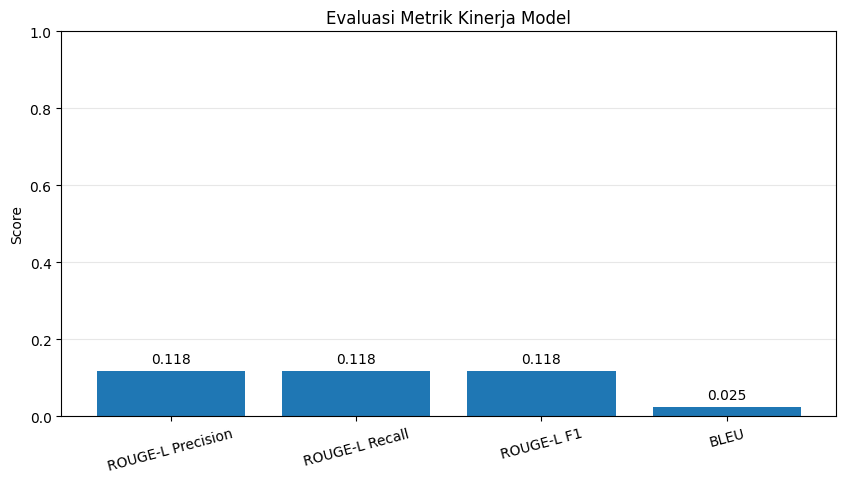

In [ ]:
import matplotlib.pyplot as plt

# ============================================
# SIAPKAN DATA UNTUK PLOT
# ============================================
rouge_p = evaluation_results['rouge_l']['precision']
rouge_r = evaluation_results['rouge_l']['recall']
rouge_f = evaluation_results['rouge_l']['f1']
bleu = evaluation_results['bleu']

metrics = ['ROUGE-L Precision', 'ROUGE-L Recall', 'ROUGE-L F1', 'BLEU']
values = [rouge_p, rouge_r, rouge_f, bleu]

# ============================================
# PLOT GRAFIK BAR METERAN
# ============================================
plt.figure(figsize=(10, 5))
plt.bar(metrics, values)
plt.title("Evaluasi Metrik Kinerja Model")
plt.ylabel("Score")
plt.ylim(0, 1)

# Tambahkan nilai di atas bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.show()

Grafik ini menampilkan nilai rata-rata metrik ROUGE-L dan BLEU dari model yang sudah diuji pada validation set. Secara umum, skor yang muncul masih tergolong rendah, dengan ROUGE-L berada di sekitar 0.118 dan BLEU sekitar 0.025. Angka ini menunjukkan bahwa kesamaan antara output model dan jawaban asli masih cukup jauh. Dengan kata lain, model kita masih perlu dilatih lebih lama, diperbaiki preprocessing-nya, atau ditingkatkan arsitekturnya supaya bisa menghasilkan jawaban yang lebih akurat dan konsisten.

### Kesimpulan Akhir

Eksperimen ini menunjukkan bagaimana desain arsitektur, kualitas preprocessing, dan skala data sangat menentukan kemampuan model dalam memahami konteks dan menghasilkan jawaban yang relevan. Perbandingan antara model-model yang diuji memberikan gambaran yang jelas mengenai peningkatan performa yang terjadi seiring dengan bertambahnya kompleksitas model serta teknik optimasi yang digunakan.

Meskipun model transformer Q&A yang dibuat oleh kelompok kami mencapai akurasi yang lebih tinggi dibanding model RNN dan LSTM yang telah kami buat sebelumnya, ROUGE-L / BLEU yang dihitung memberikan indikasi kualitas; skor rendah menunjukkan perlu lebih banyak data, regularisasi, atau arsitektur lebih besar untuk perbaikan.